In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from scipy.stats import loguniform
from xgboost import XGBClassifier

In [16]:
data = pd.read_csv("../dataset/Churn_Modelling.csv")
df = pd.DataFrame(data)
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [17]:
numerical_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]
categorical_features = ["Geography", "Gender"]

preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)


In [18]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.8,
    gamma=0.1,
    scale_pos_weight=2,
    eval_metric="auc",
    random_state=42
)

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", model)
])


In [19]:
X = df[numerical_features + categorical_features]
y = df["Exited"]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring="roc_auc")
print(f"Cv scores: {cv_scores}")

Cv scores: [0.86835988 0.85592946 0.86421398 0.86974802 0.87345435]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

In [21]:
print(classification_report(y_test, preds))
y_proba = pipeline.predict_proba(X_test)[:,1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1607
           1       0.65      0.63      0.64       393

    accuracy                           0.86      2000
   macro avg       0.78      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000

Test ROC-AUC: 0.8714767295119477
PR-AUC: 0.7076124203130073


In [22]:
param_dist = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__gamma": [0, 0.1, 0.2],
    "model__scale_pos_weight": [1, 2, 3]  # helps with class imbalance
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)


Best parameters: {'model__subsample': 0.6, 'model__scale_pos_weight': 2, 'model__n_estimators': 300, 'model__max_depth': 6, 'model__learning_rate': 0.01, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8}
Best CV ROC-AUC: 0.8653359978260353


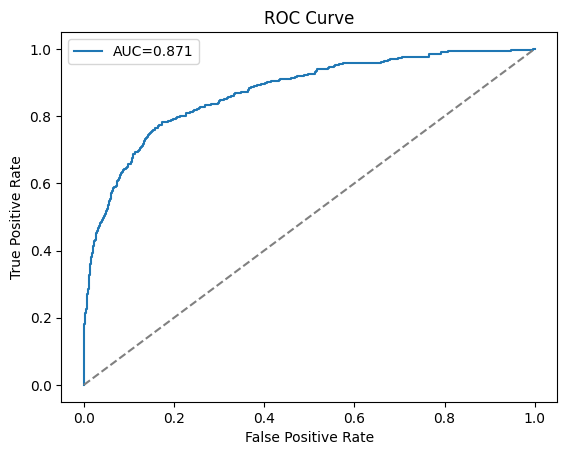

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [26]:
def evaluate_model_robustness(
    pipeline,
    X, y,
    test_sizes=(0.1, 0.2, 0.3),
    seeds=(42,),
    thresholds=(0.5,)
):
    results = []

    for ts in test_sizes:
        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=ts,
                stratify=y,
                random_state=seed
            )

            pipeline.fit(X_train, y_train)
            y_proba = pipeline.predict_proba(X_test)[:, 1]

            for t in thresholds:
                y_pred = (y_proba >= t).astype(int)

                results.append({
                    "test_size": ts,
                    "seed": seed,
                    "threshold": t,
                    "roc_auc": roc_auc_score(y_test, y_proba),
                    "pr_auc": average_precision_score(y_test, y_proba),
                    "precision": precision_score(y_test, y_pred, zero_division=0),
                    "recall": recall_score(y_test, y_pred),
                    "f1": f1_score(y_test, y_pred)
                })

    return results
results = evaluate_model_robustness(
    pipeline,
    X, y,
    test_sizes=[0.1, 0.2, 0.3],
    seeds=[0, 21, 42],
    thresholds=[0.3, 0.5, 0.7]
)

print(results)


[{'test_size': 0.1, 'seed': 0, 'threshold': 0.3, 'roc_auc': 0.8635579860084738, 'pr_auc': 0.6742655137396614, 'precision': 0.5, 'recall': 0.7647058823529411, 'f1': 0.6046511627906976}, {'test_size': 0.1, 'seed': 0, 'threshold': 0.5, 'roc_auc': 0.8635579860084738, 'pr_auc': 0.6742655137396614, 'precision': 0.6043956043956044, 'recall': 0.5392156862745098, 'f1': 0.5699481865284974}, {'test_size': 0.1, 'seed': 0, 'threshold': 0.7, 'roc_auc': 0.8635579860084738, 'pr_auc': 0.6742655137396614, 'precision': 0.7592592592592593, 'recall': 0.4019607843137255, 'f1': 0.5256410256410257}, {'test_size': 0.1, 'seed': 21, 'threshold': 0.3, 'roc_auc': 0.876077692383486, 'pr_auc': 0.7408033953532283, 'precision': 0.5049180327868853, 'recall': 0.7549019607843137, 'f1': 0.6051080550098232}, {'test_size': 0.1, 'seed': 21, 'threshold': 0.5, 'roc_auc': 0.876077692383486, 'pr_auc': 0.7408033953532283, 'precision': 0.7052631578947368, 'recall': 0.6568627450980392, 'f1': 0.6802030456852792}, {'test_size': 0.1, 